# Comparing drift detectors

We take the image classifier example and use it to compare drift detectors.

We will give an opinionated take here. This is not to take shots at the research that enables TorchDrift, but reflects that the typical application in the wild may be dissimilar to the systematic, controlled experimentation in academic papers. We believe that the purpose of TorchDrift is providing tools to do drift detection as well as presenting good practice for practitioners.

You are encouraged to study the literature, in particular [S. Rabanser et al: Failing Loudly](https://arxiv.org/abs/1810.11953), and also to do your own experimentation and draw your own conclusions.

In [1]:
import IPython
import sys
sys.path.insert(0, '../')

import copy
import tqdm
import torchvision
import functools
import torch
from typing import Optional, Any
import torch
import math
import pytorch_lightning as pl
import torchdrift
import sklearn.manifold

%matplotlib inline
from matplotlib import pyplot


In [2]:
torchvision.datasets.utils.download_and_extract_archive('https://download.pytorch.org/tutorial/hymenoptera_data.zip', 'data/')


# these are the standard transforms without the normalization (which we move into the model.step/predict before the forward)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])


class OurDataModule(pl.LightningDataModule):
    def __init__(self, parent: Optional['OurDataModule']=None, additional_transform=None):
        if parent is None:
            self.train_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/train/',
                                                                  transform=train_transform)
            self.val_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val/',
                                                                  transform=val_transform)
            self.test_dataset = torchvision.datasets.ImageFolder('./data/hymenoptera_data/test/',
                                                                  transform=val_transform)
            self.train_batch_size = 4
            self.val_batch_size = 128
            self.additional_transform = None
        else:
            self.train_dataset = parent.train_dataset
            self.val_dataset = parent.val_dataset
            self.test_dataset = parent.test_dataset
            self.train_batch_size = parent.train_batch_size
            self.val_batch_size = parent.val_batch_size
            self.additional_transform = additional_transform
        if additional_transform is not None:
            self.additional_transform = additional_transform
        
        self.prepare_data()
        self.setup('fit')
        self.setup('test')

    def setup(self, typ):
        pass
    
    def collate_fn(self, batch):
        batch = torch.utils.data._utils.collate.default_collate(batch)
        if self.additional_transform:
            batch = (self.additional_transform(batch[0]), *batch[1:])
        return batch
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.train_batch_size, 
                                           num_workers=4, shuffle=True, collate_fn=self.collate_fn)
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.val_batch_size,
                                           shuffle=False, collate_fn=self.collate_fn)
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.val_batch_size,
                                           shuffle=False, collate_fn=self.collate_fn)

    def default_dataloader(self, batch_size=None, num_samples=None, shuffle=True):
        dataset = self.val_dataset
        if batch_size is None:
            batch_size = self.val_batch_size
        replacement = num_samples is not None
        if shuffle:
            sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=num_samples)
        else:
            sampler = None
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                                           collate_fn=self.collate_fn)


datamodule = OurDataModule()


Using downloaded and verified file: data/hymenoptera_data.zip
Extracting data/hymenoptera_data.zip to data/


## Feature extractor

We use the TorchVision ResNet18 as the drift detector.


In [3]:
feature_extractor = torch.nn.Sequential(
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.resnet18(pretrained=True)
)
feature_extractor[0].fc = torch.nn.Identity()

## Simulating drifted data

For systematic experiments, we want to compare the output of the drift detector on benign (non-drifted) and and drifted, here (partially) out of distribution samples. We simulate out of distribution data by applying a gaussian blur. In reality you might have effects like the camera lense losing focus or dirt impeding the picture quality.

Note that we do not use the drifted data for "training" the drift detector, but just for evaluation!

On the technical side, we take our datamodule as the in-distribution datamodule as is and use a derived datamodule which applies the gaussian blur in addition to the usual transforms as the out of distribution datamodule.


In [4]:
def corruption_function(x: torch.Tensor):
    return torchdrift.data.functional.gaussian_blur(x, severity=2)

ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

Let us grab a few inputs and show them without and with corruption.

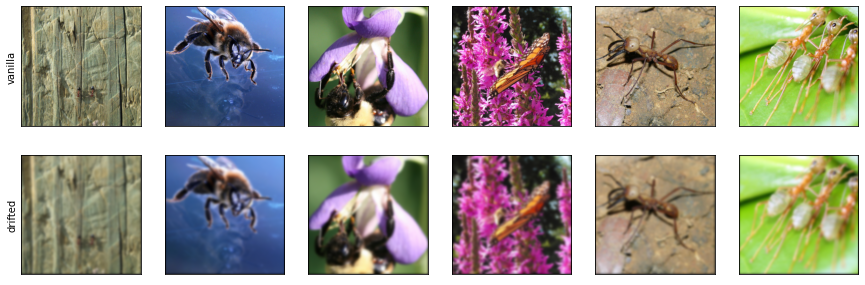

In [5]:
inputs, _ = next(iter(datamodule.default_dataloader(shuffle=True)))
inputs_ood = corruption_function(inputs)

N = 6

pyplot.figure(figsize=(15, 5))
for i in range(N):
    for j in range(2):
        pyplot.subplot(2, N, j * N + i + 1)
        if i == 0:
            pyplot.ylabel('vanilla' if j == 0 else 'drifted')
        pyplot.imshow((inputs if j == 0 else inputs_ood)[i].permute(1, 2, 0))
        pyplot.xticks([])
        pyplot.yticks([])

## Kernel MMD drift detector


Or first detector is the Kernel MMD drift detector. As you may have guessed from the name, it uses a kernel to define a metric on the space of distributions on the feature-space (see our [note on the intuition behind MMD](./note_on_mmd.ipynb)). TorchDrift implements a few kernels in the `detectors.mmd` module, the `GaussianKernel` (also known as squared exponential) is the default, `ExpKernel` (aka Laplacian Kernel) and `RationalQuadraticKernel` are also available.

In our experiments Kernel MMD worked very well, so we suggest it as a default.

In [6]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()

We use the `utils.DriftDetectionExperiment` class to drive our experiment. It lets us set a ratio of OOD samples in the drifted samples and a sample size.

While the statistical tests underpinning the drift detection could also produce p-values, we can also treat the test score as a value that can be thresholded for detection, giving the typical ROC curve. We see that for this setup, the detection power is quite strong.

100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


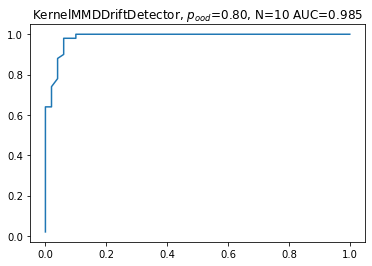

In [7]:
od_model = drift_detector
ind_datamodule = datamodule
ood_datamodule = OurDataModule(parent=datamodule, additional_transform=corruption_function)

ood_ratio = 0.8
sample_size = 10
experiment = torchdrift.utils.DriftDetectionExperiment(od_model, feature_extractor, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader())
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule)
pyplot.plot(fp, tp)
pyplot.title(label=f'{type(od_model).__name__}, $p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()

## Dimension Reduction & Kolmogorov-Smirnov test

Next up is the Kolmogorov-Smirnov two sample test.
We operationalize it by adding a dimension reduction to two PCA components (the PCA reducer estimates the PCA transform on the reference data during fitting and then applies this fixed transform to the test data).
As suggested by _Failing Loudly_, we use the Bonferroni correction and perform the KS test on the marginals.


In [8]:
red = torchdrift.reducers.pca.PCAReducer(n_components=2)
detector = torchdrift.detectors.ks.KSDriftDetector()
reducer_detector = torch.nn.Sequential(red, detector)


Next we run our experiment just like before. This combination usually gives good results, typically a bit less AUC than the Kernel MMD, but typically between just below 0.8 and 0.75.

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


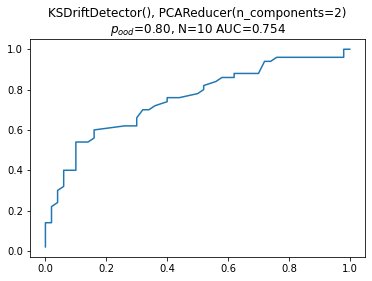

In [9]:
experiment = torchdrift.utils.DriftDetectionExperiment(reducer_detector, feature_extractor, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader())
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule)
pyplot.plot(fp, tp)
pyplot.title(label=f'{detector}, {red}\n$p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()

## Untrained Autoencoder

Finally we use the Untrained Autoencoder. This is a bit of a funny name because it really half an autoencoder, so we might as well call it a untrained or randomly initialized feature extractor. This performed reasonably well in _Failing Loudly_, so it appears relatively frequently.

In our experiments, this does not work as well as in the ones in _Failing Loudly_. Part of it may be that we have larger images so the feature extractor has "more work to do" and a purely random one does not perform as well. Another part may be that our sample size is lower. We believe that in both of these aspects, our setup is closer to (our) real-world use-cases.

Our conclusion here is that the UAE applied to images directly is not as good a choice as working with a pretrained model. Of course, we would not need to see this as a binary decision but could combine a few layers of our trained model to start off with a randomly initialized top if we think that the topmost layers are too specialized on the classification task to be useful as a drift detector.

In [10]:

feature_extractor_red = torch.nn.Sequential(
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.nn.Conv2d(3, 128, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 1024, kernel_size=5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveMaxPool2d(8),
    torch.nn.Flatten(),
    torch.nn.Linear(1024*8*8, 32)
     ).cuda().eval()

for m in feature_extractor_red:
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


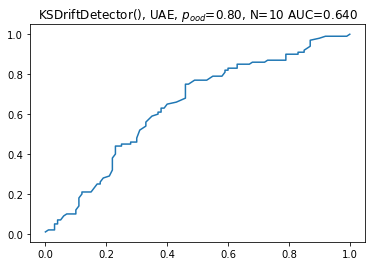

In [11]:

detector = torchdrift.detectors.ks.KSDriftDetector()
experiment = torchdrift.utils.DriftDetectionExperiment(detector, feature_extractor_red, ood_ratio=ood_ratio, sample_size=sample_size)
experiment.post_training(datamodule.train_dataloader())
auc, (fp, tp) = experiment.evaluate(ind_datamodule, ood_datamodule, num_runs=100)
pyplot.plot(fp, tp)
pyplot.title(label=f'{detector}, UAE, $p_{{ood}}$={ood_ratio:.2f}, N={sample_size} AUC={auc:.3f}')
pyplot.show()